In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Intel Image Classification – CNN Projesi
Bu proje kapsamında CNN tabanlı bir model ile 6 farklı görüntü sınıfını 
(Buildings, Forest, Glacier, Mountain, Sea, Street) sınıflandırmayı amaçlıyorum.


In [ ]:
Adımlar
1. Veri yükleme ve keşif 
2. Train/Validation/Test ayrımı
3. Data Augmentation
4. CNN modeli (Conv, Pooling, Dropout, Dense)
5. Modelin eğitimi
6. Değerlendirme (Accuracy/Loss grafikleri, CM, CR, Grad-CAM)
7. Hiperparametre denemeleri
8. Sonuçlar ve çıkarımlar


## 2) Veri Önişleme

Bu bölümde:
- Klasör yapısını doğruluyorum (train/test).
- Train setten %20 validation çıkarıyorum.
- Görselleri 224×224 boyutlandırıyorum.
- Sınıf dağılımını ve örnek görselleri gösteriyorum (EDA).
- Data augmentation katmanını hazırlıyorum (flip/rotation/zoom/contrast).
- tf.data performans ayarlarını (cache/prefetch) yapıyorum.


In [1]:
import os, random, numpy as np, tensorflow as tf  # temel kütüphaneler
import matplotlib.pyplot as plt  # grafik çizimi
from pathlib import Path  # path işlemleri 

SEED = 42   # tekrarlanabilirlik için seed
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED) # tüm kaynaklarda seed


DATA_DIR = "/kaggle/input/intel-image-classification"    
train_dir = f"{DATA_DIR}/seg_train/seg_train"   # train klasörü
test_dir  = f"{DATA_DIR}/seg_test/seg_test"   # test klasörü

print("GPU:", tf.config.list_physical_devices('GPU'))   # GPU var mı?
print("Train path exists:", os.path.exists(train_dir))   # train yolu kontrol
print("Test  path exists:", os.path.exists(test_dir))     # test yolu kontrol


!ls -lah /kaggle/input/intel-image-classification   # dataset kökü listele
!ls -lah /kaggle/input/intel-image-classification/seg_train/seg_train | head -n 10  # train içeriği


2025-09-26 18:38:31.226676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758911911.625595      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758911911.733194      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Train path exists: True
Test  path exists: True
total 4.0K
drwxr-xr-x 5 nobody nogroup    0 Aug 31 10:01 .
drwxr-xr-x 3 root   root    4.0K Sep 26 18:31 ..
drwxr-xr-x 3 nobody nogroup    0 Aug 31 10:00 seg_pred
drwxr-xr-x 3 nobody nogroup    0 Aug 31 10:01 seg_test
drwxr-xr-x 3 nobody nogroup    0 Aug 31 10:01 seg_train
total 0
drwxr-xr-x 8 nobody nogroup 0 Aug 31 10:01 .
drwxr-xr-x 3 nobody nogroup 0 Aug 31 10:01 ..
drwxr-xr-x 2 nobody nogroup 0 Aug 31 10:01 buildings
drwxr-xr-x 2 nobody nogroup 0 Aug 31 10:01 forest
drwxr-xr-x 2 nobody nogroup 0 Aug 31 10:01 glacier
drwxr-xr-x 2 nobody nogroup 0 Aug 31 10:01 mountain
drwxr-xr-x 2 nobody nogroup 0 Aug 31 10:01 sea
drwxr-xr-x 2 nobody nogroup 0 Aug 31 10:01 street


In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory # klasörden tf.data dataset

IMG_SIZE = (224, 224) #Tüm görselleri modele girmeden önce 224×224’e yeniden boyutlandırılır.
BATCH = 32  # batch boyutu- her adımda 32 görüntü için
AUTOTUNE = tf.data.AUTOTUNE 

# Train içinden %20 validation ayırıyoruz
train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.20, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH
)
# aynı split/seed ile validation dataset
val_ds = image_dataset_from_directory(
    train_dir,
    validation_split=0.20, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH
)

# Test set (ayrı klasörden)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)

class_names = train_ds.class_names  # sınıf adları 
num_classes = len(class_names)   # sınıf sayısı
class_names, num_classes    # hızlı kontrol (Jupyter çıktısı)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


I0000 00:00:1758911969.246311      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758911969.247115      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'], 6)

In [4]:
# Eğitim sırasında okuma performansı için:
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


In [5]:
# Klasörlerden dosya sayısı 
counts = {}
# eğitim klasöründeki sınıf klasörleri alfabetik taranır
for cls in sorted(os.listdir(train_dir)):
    p = Path(train_dir) / cls   # sınıf klasörünün yolu
    if p.is_dir(): # yalnızca klasör olanlar dikkate alınır
        counts[cls] = len(list(p.glob("*")))  # üst seviye dosya sayısı hesaplanır
counts


{'buildings': 2191,
 'forest': 2271,
 'glacier': 2404,
 'mountain': 2512,
 'sea': 2274,
 'street': 2382}

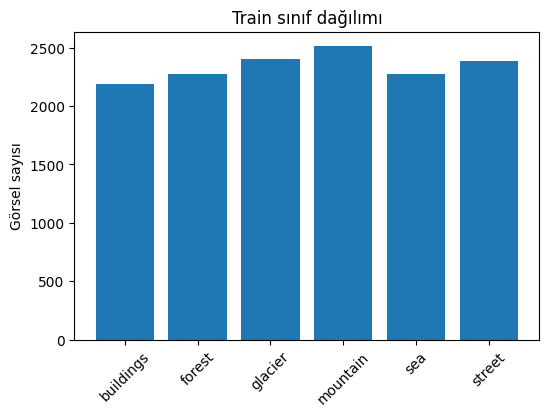

In [6]:
import matplotlib.pyplot as plt # görselleştirme arayüzü

labels = list(counts.keys())   # sınıf adları (x-ekseni)
values = [counts[k] for k in labels]     # sınıf başına örnek sayısı (y-ekseni)
 
plt.figure(figsize=(6,4))  # tuval boyutu
plt.bar(labels, values)    # çubuk grafik
plt.title("Train sınıf dağılımı")  # başlık
plt.xticks(rotation=45)   # x etiketlerini döndür
plt.ylabel("Görsel sayısı")    # y ekseni açıklaması
plt.show()     # grafik görüntülenir


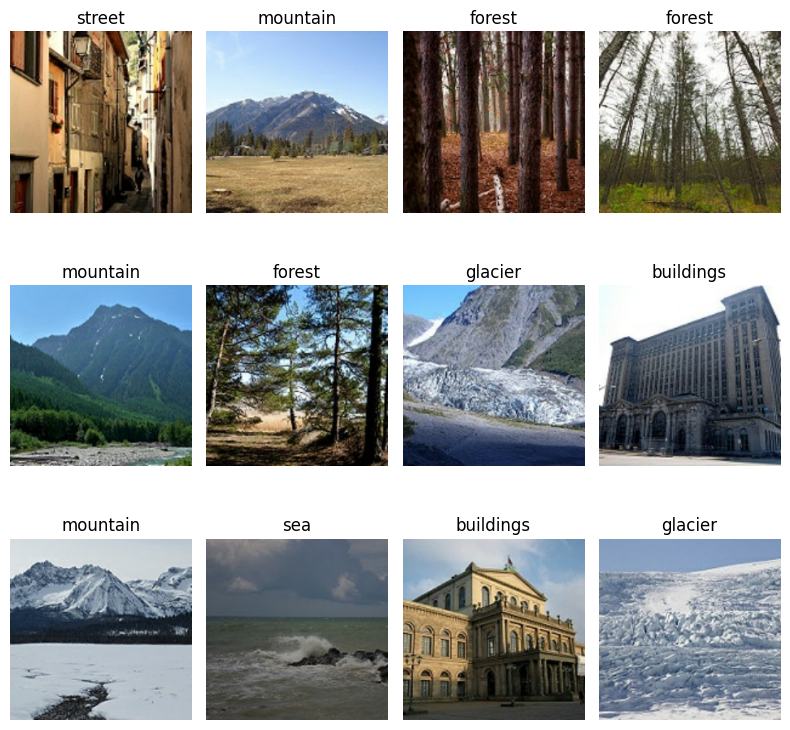

In [7]:
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):  # tek bir batch alınıyor
    for i in range(12):  # ilk 12 örnek görselleştiriliyor
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")  # eksenleri gizlemek için 
plt.tight_layout(); plt.show()  # Kenar boşlukları otomatik ayarlanır ve grafik gösterilir.


In [8]:
try:
    train_ds     # train_ds tanımlı mı kontrolü
except NameError: #tanımlı değilse aşağıdaki “yeniden kurulum” bloğu çalıştırılır.
    from tensorflow.keras.preprocessing import image_dataset_from_directory #Klasör yapısından tf.data.Dataset üretmek için gerekli yardımcı fonksiyon içe aktarılır.
    SEED = 42; IMG_SIZE=(224,224); BATCH=32 #Tekrarlanabilirlik, hedef giriş boyutu ve batch büyüklüğü sabitleri tanımlanır.
    DATA_DIR="/kaggle/input/intel-image-classification"
    train_dir=f"{DATA_DIR}/seg_train/seg_train"   # Train klasörü - Eğitim verisinin bulunduğu klasör yolu oluşturulur.
    train_ds = image_dataset_from_directory(
        train_dir, validation_split=0.20, subset="training", seed=SEED,
        image_size=IMG_SIZE, batch_size=BATCH
    )
    class_names = train_ds.class_names  # sınıf adları 


In [9]:
import tensorflow as tf #TensorFlow çekirdeği içe aktarılır.
from tensorflow.keras import Sequential #Birden çok katmanı sıralı biçimde tanımlamak için Sequential sınıfı alınır.
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast #Eğitim sırasında anlık veri çoğaltma yapan ön-işleme katmanları içe aktarılır.

data_augmentation = Sequential([
    RandomFlip("horizontal"),   # yatay çevirme
    RandomRotation(0.15),       # küçük açısal döndürme (faktör=0.15)
    RandomZoom(0.10),       
    RandomContrast(0.10),       
], name="augmentation")

data_augmentation


<Sequential name=augmentation, built=False>

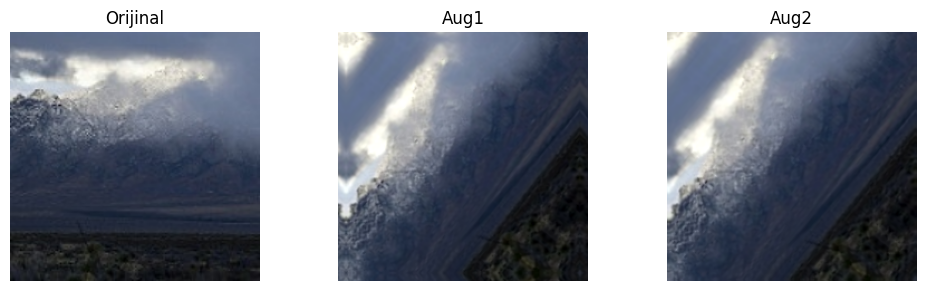

In [10]:
# train'den tek batch al, ilk görseli 1'lik batch olarak seç
for images, labels in train_ds.take(1):
    sample = images[0:1]
    break

import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))

# Orijinal
plt.subplot(1,3,1); plt.imshow(sample[0].numpy().astype("uint8")); plt.title("Orijinal"); plt.axis("off")

# Aug1
aug1 = data_augmentation(sample, training=True)
plt.subplot(1,3,2); plt.imshow(aug1[0].numpy().astype("uint8")); plt.title("Aug1"); plt.axis("off")

# Aug2
aug2 = data_augmentation(sample, training=True)
plt.subplot(1,3,3); plt.imshow(aug2[0].numpy().astype("uint8")); plt.title("Aug2"); plt.axis("off")

plt.tight_layout(); plt.show()  # düzenle ve göster


In [11]:
AUTOTUNE = tf.data.AUTOTUNE  # tf.data için otomatik ön getirme/işleme ayarı

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)

# Eğer daha önce val_ds ve test_ds oluşturdıysan bunları da hızlandır:
try:
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)
except NameError:
    pass  # henüz tanımlı değilse  geç


In [12]:
# importlar
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# sınıf sayısı 
class_names = class_names if 'class_names' in globals() else train_ds.class_names
num_classes = len(class_names)

try:
    data_augmentation
except NameError:
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.15),
        RandomZoom(0.10),
        RandomContrast(0.10),
    ], name="augmentation")

def build_baseline(input_shape=(224,224,3), num_classes=6, l2=1e-4, dropout=0.3):
    inputs = keras.Input(shape=input_shape)

    x = data_augmentation(inputs)         
    x = layers.Rescaling(1./255)(x)          # [0,1] ölçek

    # conv blokları
    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(dropout)(x)           # ← katmanı tensora uygula
    x = layers.Flatten()(x)                  # vektörleştir
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)           # ← yine tensora uygula
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="cnn_baseline")

model = build_baseline(num_classes=num_classes)
model.summary()


Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,206 (49.36 MB)

 Trainable params: 12,939,206 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# derle (integer label → sparse loss)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# callback'ler
ckpt   = keras.callbacks.ModelCheckpoint("best_baseline.keras", monitor="val_accuracy",
                                         save_best_only=True, mode="max")   # en iyiyi kaydet
early  = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                       patience=5, restore_best_weights=True)  # erken dur
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                           factor=0.5, patience=2, verbose=1)  # lr düşür

EPOCHS = 20  # istersen 15-30 arası dene
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, early, reduce],
    verbose=1
)


Epoch 1/20


E0000 00:00:1758912141.149587      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cnn_baseline_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1758912141.897423     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 120ms/step - accuracy: 0.4303 - loss: 1.5394 - val_accuracy: 0.5830 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.5927 - loss: 1.0729 - val_accuracy: 0.6718 - val_loss: 0.8994 - learning_rate: 0.0010
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.6335 - loss: 0.9969 - val_accuracy: 0.6757 - val_loss: 0.8835 - learning_rate: 0.0010
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.6479 - loss: 0.9405 - val_accuracy: 0.7313 - val_loss: 0.7277 - learning_rate: 0.0010
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.6903 - loss: 0.8541 - val_accuracy: 0.7267 - val_loss: 0.7519 - learning_rate: 0.0010
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6831 - loss: 0.8441
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.6832 - loss: 0.8441 

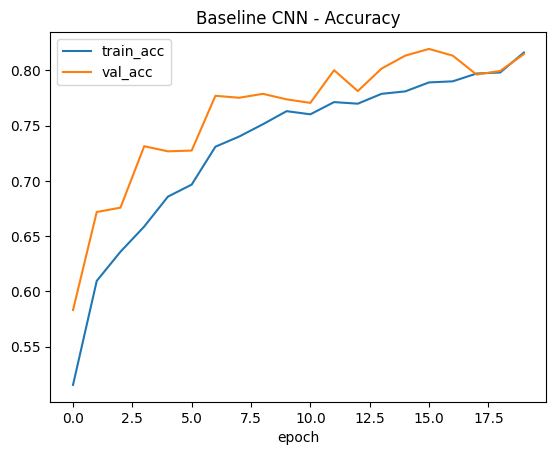

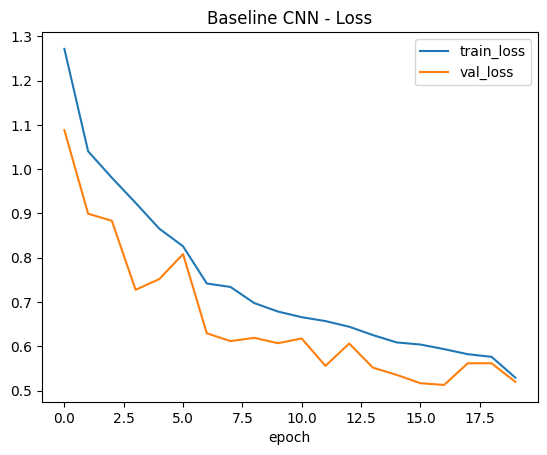

In [14]:
# eğitim/val eğrilerini çizmek için
import matplotlib.pyplot as plt

def plot_history(h, title="Baseline CNN"):
    acc = h.history.get("accuracy", [])
    val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])

    plt.figure()
    plt.plot(acc, label="train_acc"); plt.plot(val_acc, label="val_acc")
    plt.title(f"{title} - Accuracy"); plt.xlabel("epoch"); plt.legend()

    plt.figure()
    plt.plot(loss, label="train_loss"); plt.plot(val_loss, label="val_loss")
    plt.title(f"{title} - Loss"); plt.xlabel("epoch"); plt.legend()

plot_history(history)


              precision    recall  f1-score   support

   buildings       0.74      0.82      0.78       430
      forest       0.96      0.97      0.96       436
     glacier       0.82      0.76      0.79       473
    mountain       0.75      0.76      0.75       514
         sea       0.83      0.77      0.80       477
      street       0.84      0.86      0.85       476

    accuracy                           0.82      2806
   macro avg       0.82      0.82      0.82      2806
weighted avg       0.82      0.82      0.82      2806



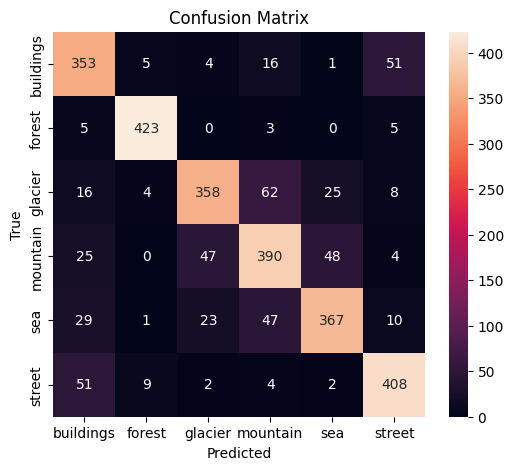

In [15]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# tahminleri topla
y_true, y_pred = [], []
for X, y in val_ds:
    p = model.predict(X, verbose=0)
    y_true.extend(y.numpy())
    y_pred.extend(np.argmax(p, axis=1))

y_true = np.array(y_true); y_pred = np.array(y_pred)

# rapor + matris
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)

# görselleştir 
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()
except Exception:
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues"); plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


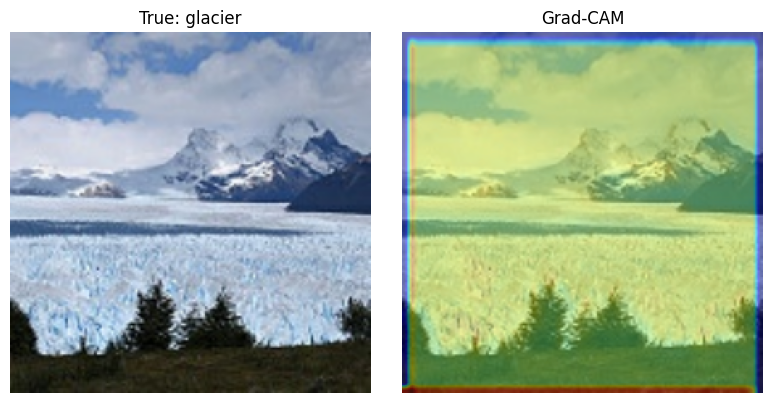

In [16]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_last_conv_name(m):
    # sondan ilk Conv2D'yi bul
    for layer in reversed(m.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Conv2D katmanı bulunamadı.")

def grad_cam_heatmap(m, img_tensor, last_conv_layer_name=None, pred_index=None):
    # img_tensor: (1, H, W, 3) float32
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_name(m)

    grad_model = tf.keras.Model([m.inputs],
                                [m.get_layer(last_conv_layer_name).output, m.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    grads = tape.gradient(loss, conv_out)            # dloss/dconv
    pooled = tf.reduce_mean(grads, axis=(0,1,2))     # kanal ağırlıkları
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(pooled * conv_out, axis=-1)

    # normalize [0,1]
    heatmap = tf.maximum(heatmap, 0)
    denom = tf.reduce_max(heatmap) + 1e-8
    heatmap = heatmap / denom
    return heatmap.numpy()

# val setinden bir örnek al ve Grad-CAM göster
for images, labels in val_ds.take(1):
    img = images[0:1]                 # (1,224,224,3) uint8
    lbl = labels[0].numpy()
    break

# model girişi gibi ölçekle: (aug içinde rescaling var ama görselleştirme için img/255 kullanacağız)
img_float = tf.cast(img, tf.float32) / 255.0
hm = grad_cam_heatmap(model, img_float)             # 2D heatmap

# görselleştir: orijinal + overlay
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img[0].numpy().astype("uint8")); plt.title(f"True: {class_names[lbl]}"); plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img[0].numpy().astype("uint8"));        # arka plan
plt.imshow(tf.image.resize(hm[...,None], (img.shape[1], img.shape[2]))[...,0],
           cmap="jet", alpha=0.4)                   
plt.title("Grad-CAM"); plt.axis("off")
plt.tight_layout(); plt.show()


In [17]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"TEST acc: {test_acc:.3f} | loss: {test_loss:.3f}")


TEST acc: 0.820 | loss: 0.516


In [18]:
# derlemek için
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),  
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# callback'ler
ckpt   = keras.callbacks.ModelCheckpoint("best_baseline.keras", monitor="val_accuracy",
                                         save_best_only=True, mode="max")   # en iyiyi kaydet
early  = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                       patience=5, restore_best_weights=True)  
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                           factor=0.5, patience=2, verbose=1)  # lr düşür

EPOCHS = 20  # hızlı denemede 10-15 de olur
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, early, reduce],
    verbose=1
)

# hızlı skor (val + test)
val_loss,  val_acc  = model.evaluate(val_ds,  verbose=0)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"VAL  acc: {val_acc:.3f} | loss: {val_loss:.3f}")
print(f"TEST acc: {test_acc:.3f} | loss: {test_loss:.3f}")


Epoch 1/20


E0000 00:00:1758912841.683867      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cnn_baseline_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


351/351 ━━━━━━━━━━━━━━━━━━━━ 36s 93ms/step - accuracy: 0.7735 - loss: 0.6511 - val_accuracy: 0.7929 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.7692 - loss: 0.6442 - val_accuracy: 0.8086 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.7936 - loss: 0.6177 - val_accuracy: 0.7776 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.7896 - loss: 0.6051 - val_accuracy: 0.8168 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.7977 - loss: 0.5951 - val_accuracy: 0.7922 - val_loss: 0.5919 - learning_rate: 0.0010
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7858 - loss: 0.6053
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.7858 - loss: 0.6053 -

In [20]:
# MobileNetV2 tabanı (dondur + üstüne sınıflandırıcı ekle)
base = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3), include_top=False, weights="imagenet")
base.trainable = False  # önce dondur

inputs = keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
tl_model = keras.Model(inputs, outputs, name="mobilenetv2_tl")

tl_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
tl_hist = tl_model.fit(train_ds, validation_data=val_ds, epochs=5,
                       callbacks=[early, reduce, ckpt])

base.trainable = True
for layer in base.layers[:-30]:
    layer.trainable = False

tl_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
tl_fine = tl_model.fit(train_ds, validation_data=val_ds, epochs=5,
                       callbacks=[early, reduce, ckpt])


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.6754 - loss: 0.8587 - val_accuracy: 0.8924 - val_loss: 0.3015 - learning_rate: 0.0010
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.8542 - loss: 0.3999 - val_accuracy: 0.8956 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.8656 - loss: 0.3650 - val_accuracy: 0.9066 - val_loss: 0.2571 - learning_rate: 0.0010
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.8738 - loss: 0.3489 - val_accuracy: 0.9038 - val_loss: 0.2693 - learning_rate: 0.0010
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8784 - loss: 0.3251
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
351/351 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.8783 - loss: 0.3252 - val_accuracy: 0.9091 - val_loss: 0.2664 - learning_rate: 0.0010
Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 86ms/step - accuracy: 0.8408 - loss: 0.4

In [ ]:

FAST = False 
%matplotlib inline
def plot_history(h, title="Model"):
    if h is None or not hasattr(h, "history"):
        print("history bulunamadı → önce model.fit(...)")
        return
    import matplotlib.pyplot as plt
    acc, val_acc = h.history.get("accuracy", []), h.history.get("val_accuracy", [])
    loss, val_loss = h.history.get("loss", []), h.history.get("val_loss", [])
    plt.figure(); plt.plot(acc,label="train_acc"); plt.plot(val_acc,label="val_acc"); plt.title(f"{title}-Acc"); plt.legend()
    plt.figure(); plt.plot(loss,label="train_loss"); plt.plot(val_loss,label="val_loss"); plt.title(f"{title}-Loss"); plt.legend()

plot_history(globals().get("history", None), "Baseline CNN")


import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

test_iter = test_ds.take(10) if FAST else test_ds  # hızlı/ tam
y_true = np.concatenate([y.numpy() for _, y in test_iter], axis=0)
y_pred = np.argmax(model.predict(test_iter, verbose=0), axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
try:
    import seaborn as sns
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.tight_layout(); plt.show()
except Exception:
    plt.figure(figsize=(6,5)); plt.imshow(cm, cmap="Blues"); plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()


import tensorflow as tf

def get_last_conv_name(m):
    for layer in reversed(m.layers):
        if isinstance(layer, tf.keras.layers.Conv2D): return layer.name
    raise ValueError("Conv2D bulunamadı.")

def grad_cam_heatmap(m, img_tensor, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_name(m)
    grad_model = tf.keras.Model([m.inputs],
                                [m.get_layer(last_conv_layer_name).output, m.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        loss = preds[:, tf.argmax(preds[0])]
    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(weights * conv_out, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

n_show = 3 if FAST else 6
for imgs, labels in test_ds.take(1):  
    for i in range(min(n_show, len(imgs))):
        img  = imgs[i:i+1]
        lbl  = labels[i].numpy()
        imgf = tf.cast(img, tf.float32)   
        hm   = grad_cam_heatmap(model, imgf)
        hm   = tf.image.resize(hm[...,None], (img.shape[1], img.shape[2]))[...,0]

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img[0].numpy().astype("uint8"))
        plt.title(f"True: {class_names[lbl]}"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(img[0].numpy().astype("uint8"))
        plt.imshow(hm, cmap="jet", alpha=0.4)
        pred = class_names[int(tf.argmax(model(imgf, training=False), axis=1)[0])]
        plt.title(f"Grad-CAM (Pred: {pred})"); plt.axis("off")
        plt.tight_layout(); plt.show()


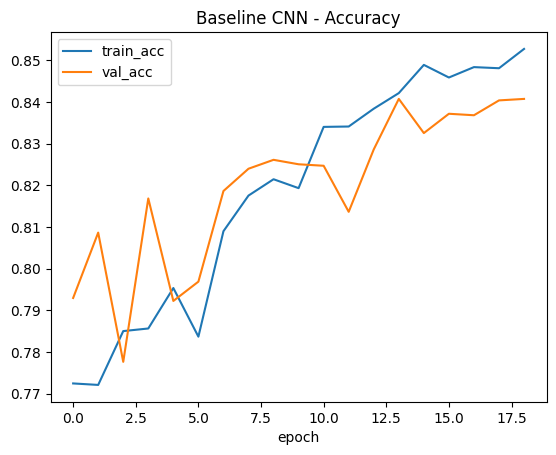

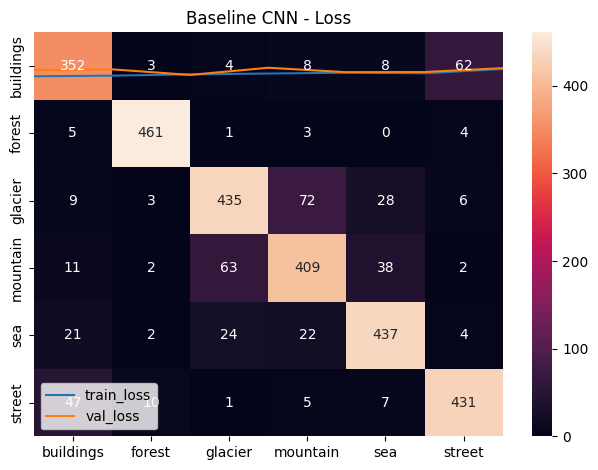

In [21]:
# Acc/Loss grafiğini kaydetmek için
plot_history(history, "Baseline CNN")
import matplotlib.pyplot as plt
plt.savefig("acc_loss_baseline.png", dpi=200, bbox_inches="tight")

# Test raporu + CM’yi kaydetmek için
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds, verbose=0), axis=1)
with open("classification_report_test.txt","w") as f:
    f.write(classification_report(y_true, y_pred, target_names=class_names))
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.tight_layout(); plt.savefig("cm_test.png", dpi=200); plt.show()


In [22]:
# parametrik CNN (blok sayısı, filtre, kernel, dropout, dense, l2)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_cnn(input_shape=(224,224,3), num_classes=6,
              num_blocks=3, base_filters=32, kernel_size=3,
              dense_units=128, dropout=0.3, l2=1e-4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)        # aug
    x = layers.Rescaling(1./255)(x)      # [0,1]

    # conv blokları
    f = base_filters
    for b in range(num_blocks):
        x = layers.Conv2D(f, kernel_size, padding="same", activation="relu",
                          kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.MaxPooling2D()(x)
        f *= 2  # her blokta kanal sayısını artırır

    x = layers.Dropout(dropout)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def make_optimizer(name="adam", lr=1e-3):
    name = name.lower()
    if name == "adam":
        return keras.optimizers.Adam(lr)
    if name == "rmsprop":
        return keras.optimizers.RMSprop(lr)
    # sgd (momentumlu)
    return keras.optimizers.SGD(lr, momentum=0.9, nesterov=True)

def compile_model(model, opt_name="adam", lr=1e-3):
    opt = make_optimizer(opt_name, lr)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

def rebatched(ds, bs):
   
    return ds.unbatch().batch(bs).prefetch(AUTOTUNE)

def train_eval(cfg, fast=True):
    """
    cfg: dict → {num_blocks, base_filters, kernel_size, dense_units, dropout, l2, lr, opt, batch}
    fast=True → hızlı deneme (train/val'in küçük dilimi, az epoch)
    """
    # batch ayarı
    bs = cfg.get("batch", 32)
    tr = rebatched(train_ds, bs)
    va = rebatched(val_ds,   bs)

  
    if fast:
        tr = tr.take(120)   
        va = va.take(40)
        epochs = 8
    else:
        epochs = 20


    m = build_cnn(num_classes=len(class_names),
                  num_blocks=cfg["num_blocks"],
                  base_filters=cfg["base_filters"],
                  kernel_size=cfg["kernel_size"],
                  dense_units=cfg["dense_units"],
                  dropout=cfg["dropout"],
                  l2=cfg["l2"])
    m = compile_model(m, opt_name=cfg["opt"], lr=cfg["lr"])

    # callback'ler
    cbs = [
        keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3,
                                      restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                          patience=2, verbose=0),
    ]

    h = m.fit(tr, validation_data=va, epochs=epochs, verbose=0, callbacks=cbs)
   
    best_val = max(h.history.get("val_accuracy", [0.0]))
    return best_val, h, m


In [24]:
import itertools, random


space = {
    "num_blocks":   [2, 3],         # katman/derinlik
    "base_filters": [32, 48],       # başlangıç kanal sayısı
    "kernel_size":  [3, 5],         # kernel boyutu
    "dense_units":  [128, 256],     # FC boyutu
    "dropout":      [0.3, 0.4],     # dropout
    "l2":           [1e-4, 5e-4],   # L2 ceza
    "lr":           [1e-3, 5e-4],   # öğrenme hızı
    "opt":          ["adam", "sgd"],# optimizer
    "batch":        [32, 64],       # batch size
}


all_cfgs = [
    dict(zip(space.keys(), vals))
    for vals in itertools.product(*space.values())
]
random.seed(42)
SAMPLE = 16   
trial_cfgs = random.sample(all_cfgs, k=min(SAMPLE, len(all_cfgs)))
len(trial_cfgs)


16

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os

SEED = 42
DATA_DIR = "/kaggle/input/intel-image-classification"
train_dir = f"{DATA_DIR}/seg_train/seg_train"
test_dir  = f"{DATA_DIR}/seg_test/seg_test"

IMG_SIZE = (224, 224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE


train_ds_raw = image_dataset_from_directory(
    train_dir,
    validation_split=0.20, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH
)
val_ds_raw = image_dataset_from_directory(
    train_dir,
    validation_split=0.20, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH
)
test_ds_raw = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False
)


class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("classes:", class_names)

train_ds = train_ds_raw.cache().prefetch(AUTOTUNE)
val_ds   = val_ds_raw.cache().prefetch(AUTOTUNE)
test_ds  = test_ds_raw.cache().prefetch(AUTOTUNE)


if 'data_augmentation' not in globals():
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.15),
        RandomZoom(0.10),
        RandomContrast(0.10),
    ], name="augmentation")

print("train/val/test hazır.")


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train/val/test hazır.


In [26]:
# küçük log temizliği + GPU güvenliği
import os, gc, tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
try:
    tf.get_logger().setLevel("ERROR")
    tf.config.optimizer.set_experimental_options({'layout_optimizer': False})
    for g in tf.config.list_physical_devices('GPU'):
        try: tf.config.experimental.set_memory_growth(g, True)
        except: pass
except: pass

def _clear():

    tf.keras.backend.clear_session(); gc.collect()

AUTOTUNE = tf.data.AUTOTUNE
def rebatched(ds, bs):
    # batch boyutunu değiştirir
    return ds.unbatch().batch(bs).prefetch(AUTOTUNE)


In [27]:
# parametrik CNN kurucu
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_cnn(input_shape=(224,224,3), num_classes=6,
              num_blocks=3, base_filters=32, kernel_size=3,
              dense_units=128, dropout=0.3, l2=1e-4):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)           # aug
    x = layers.Rescaling(1./255)(x)         # [0,1]

    f = base_filters
    for _ in range(num_blocks):             # derinlik = blok sayısı
        x = layers.Conv2D(f, kernel_size, padding="same", activation="relu",
                          kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.MaxPooling2D()(x)
        f *= 2                               # kanal sayısını artırır

    x = layers.Dropout(dropout)(x)          # overfit freni
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def compile_model(model, opt_name="adam", lr=1e-3):
    opt_name = opt_name.lower()
    if opt_name == "adam":
        opt = keras.optimizers.Adam(lr)
    elif opt_name == "rmsprop":
        opt = keras.optimizers.RMSprop(lr)
    else:
        opt = keras.optimizers.SGD(lr, momentum=0.9, nesterov=True)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [28]:

def train_eval_quick(cfg):
    _clear()

    
    bs = min(cfg.get("batch", 32), 32)

  
    steps_tr, steps_va, epochs = 40, 12, 3
    tr = rebatched(train_ds, bs).take(steps_tr).repeat()
    va = rebatched(val_ds,   bs).take(steps_va).repeat()

    try:
        m = build_cnn(num_classes=len(class_names),
                      num_blocks=cfg["num_blocks"],
                      base_filters=cfg["base_filters"],
                      kernel_size=cfg["kernel_size"],
                      dense_units=cfg["dense_units"],
                      dropout=cfg["dropout"],
                      l2=cfg["l2"])
        m = compile_model(m, opt_name=cfg["opt"], lr=cfg["lr"])

        h = m.fit(tr, validation_data=va, epochs=epochs,
                  steps_per_epoch=steps_tr, validation_steps=steps_va,
                  verbose=0,
                  callbacks=[
                      keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
                      keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=0),
                  ])
        best_val = max(h.history.get("val_accuracy", [0.0]))
        return best_val, h, m

    except tf.errors.ResourceExhaustedError:
      
        _clear()
        bs2 = max(8, bs // 2)
        tr = rebatched(train_ds, bs2).take(steps_tr).repeat()
        va = rebatched(val_ds,   bs2).take(steps_va).repeat()

        bf2 = max(16, cfg["base_filters"] // 2)
        m = build_cnn(num_classes=len(class_names),
                      num_blocks=cfg["num_blocks"],
                      base_filters=bf2,
                      kernel_size=cfg["kernel_size"],
                      dense_units=cfg["dense_units"],
                      dropout=cfg["dropout"],
                      l2=cfg["l2"])
        m = compile_model(m, opt_name=cfg["opt"], lr=cfg["lr"])

        h = m.fit(tr, validation_data=va, epochs=epochs,
                  steps_per_epoch=steps_tr, validation_steps=steps_va,
                  verbose=0,
                  callbacks=[
                      keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
                      keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=0),
                  ])
        best_val = max(h.history.get("val_accuracy", [0.0]))
        print(f"[OOM çözüldü] batch->{bs2}, base_filters->{bf2}")
        return best_val, h, m


In [29]:
# 6 mantıklı kombinasyon (katman/filtre/kernel/dropout/dense/l2/lr/opt/batch)
trial_cfgs = [
  {'num_blocks':2,'base_filters':32,'kernel_size':3,'dense_units':128,'dropout':0.3,'l2':1e-4,'lr':1e-3,'opt':'adam','batch':32},
  {'num_blocks':3,'base_filters':32,'kernel_size':3,'dense_units':128,'dropout':0.4,'l2':5e-4,'lr':1e-3,'opt':'adam','batch':32},
  {'num_blocks':3,'base_filters':48,'kernel_size':3,'dense_units':256,'dropout':0.3,'l2':1e-4,'lr':5e-4,'opt':'adam','batch':32},
  {'num_blocks':2,'base_filters':48,'kernel_size':5,'dense_units':256,'dropout':0.4,'l2':5e-4,'lr':1e-3,'opt':'sgd','batch':32},
  {'num_blocks':3,'base_filters':32,'kernel_size':5,'dense_units':256,'dropout':0.3,'l2':5e-4,'lr':5e-4,'opt':'sgd','batch':32},
  {'num_blocks':2,'base_filters':32,'kernel_size':3,'dense_units':128,'dropout':0.3,'l2':1e-4,'lr':5e-4,'opt':'adam','batch':32},
]
print("trial_cfgs hazır:", len(trial_cfgs), "deneme")


trial_cfgs hazır: 6 deneme


In [30]:

results = []
best = {"val_acc": -1, "cfg": None}

for i, cfg in enumerate(trial_cfgs, 1):
    val_acc, _, _ = train_eval_quick(cfg)
    results.append((val_acc, cfg))
    if val_acc > best["val_acc"]:
        best = {"val_acc": val_acc, "cfg": cfg}
    print(f"[{i}/{len(trial_cfgs)}] val_acc={val_acc:.4f}  cfg={cfg}")


results_sorted = sorted(results, key=lambda x: x[0], reverse=True)[:3]
print("\nTOP-3 (val_acc):")
for rank, (score, cfg) in enumerate(results_sorted, 1):
    print(f"{rank}. {score:.4f}  {cfg}")

print("\nSEÇİLEN (hızlı arama):", best["cfg"], "val_acc=", round(best["val_acc"], 4))


[1/6] val_acc=0.5859  cfg={'num_blocks': 2, 'base_filters': 32, 'kernel_size': 3, 'dense_units': 128, 'dropout': 0.3, 'l2': 0.0001, 'lr': 0.001, 'opt': 'adam', 'batch': 32}
[2/6] val_acc=0.5651  cfg={'num_blocks': 3, 'base_filters': 32, 'kernel_size': 3, 'dense_units': 128, 'dropout': 0.4, 'l2': 0.0005, 'lr': 0.001, 'opt': 'adam', 'batch': 32}
[3/6] val_acc=0.6276  cfg={'num_blocks': 3, 'base_filters': 48, 'kernel_size': 3, 'dense_units': 256, 'dropout': 0.3, 'l2': 0.0001, 'lr': 0.0005, 'opt': 'adam', 'batch': 32}
[4/6] val_acc=0.4844  cfg={'num_blocks': 2, 'base_filters': 48, 'kernel_size': 5, 'dense_units': 256, 'dropout': 0.4, 'l2': 0.0005, 'lr': 0.001, 'opt': 'sgd', 'batch': 32}
[5/6] val_acc=0.4714  cfg={'num_blocks': 3, 'base_filters': 32, 'kernel_size': 5, 'dense_units': 256, 'dropout': 0.3, 'l2': 0.0005, 'lr': 0.0005, 'opt': 'sgd', 'batch': 32}
[6/6] val_acc=0.5964  cfg={'num_blocks': 2, 'base_filters': 32, 'kernel_size': 3, 'dense_units': 128, 'dropout': 0.3, 'l2': 0.0001, 'lr

In [ ]:
# seçilen konfigürasyon
final_cfg = best["cfg"]
print("Tam eğitim cfg:", final_cfg)

# dataset'i seçilen batch'e göre hazırla
bs = final_cfg.get("batch", 32)
tr_full = rebatched(train_ds, bs)
va_full = rebatched(val_ds,   bs)

# model kur + derle
final_model = build_cnn(num_classes=len(class_names),
                        num_blocks=final_cfg["num_blocks"],
                        base_filters=final_cfg["base_filters"],
                        kernel_size=final_cfg["kernel_size"],
                        dense_units=final_cfg["dense_units"],
                        dropout=final_cfg["dropout"],
                        l2=final_cfg["l2"])
final_model = compile_model(final_model, opt_name=final_cfg["opt"], lr=final_cfg["lr"])

# callback'ler
from tensorflow import keras
ckpt_final = "best_tuned.keras"
cbs_final = [
    keras.callbacks.ModelCheckpoint(ckpt_final, monitor="val_accuracy",
                                    save_best_only=True, mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5,
                                  restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                                      patience=2, verbose=1),
]

EPOCHS_FULL = 20  
history_tuned = final_model.fit(
    tr_full, validation_data=va_full,
    epochs=EPOCHS_FULL, callbacks=cbs_final, verbose=1
)


val_loss,  val_acc  = final_model.evaluate(va_full,                verbose=0)
test_loss, test_acc = final_model.evaluate(rebatched(test_ds, bs), verbose=0)
print(f"[TUNED] VAL  acc: {val_acc:.3f} | loss: {val_loss:.3f}")
print(f"[TUNED] TEST acc: {test_acc:.3f} | loss: {test_loss:.3f}")


Tam eğitim cfg: {'num_blocks': 3, 'base_filters': 48, 'kernel_size': 3, 'dense_units': 256, 'dropout': 0.3, 'l2': 0.0001, 'lr': 0.0005, 'opt': 'adam', 'batch': 32}
Epoch 1/20
    351/Unknown 60s 163ms/step - accuracy: 0.4473 - loss: 1.4858

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 180ms/step - accuracy: 0.4476 - loss: 1.4850 - val_accuracy: 0.6379 - val_loss: 0.9299 - learning_rate: 5.0000e-04
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.6125 - loss: 1.0202 - val_accuracy: 0.7014 - val_loss: 0.8244 - learning_rate: 5.0000e-04
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.6501 - loss: 0.9328 - val_accuracy: 0.7459 - val_loss: 0.7190 - learning_rate: 5.0000e-04
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.6890 - loss: 0.8429 - val_accuracy: 0.7530 - val_loss: 0.6764 - learning_rate: 5.0000e-04
Epoch 5/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 172ms/step - accuracy: 0.7170 - loss: 0.7845 - val_accuracy: 0.7698 - val_loss: 0.6509 - learning_rate: 5.0000e-04
Epoch 6/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.7310 - loss: 0.7469 - val_accuracy: 0.7901 - val_loss: 0.5943 - learning_rate: 5.0000e-04
Epoch 7/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - 

2025-09-26 19:35:24.639887: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 17179869184 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1758915324.639950     107 device_host_allocator.h:61] could not allocate pinned host memory of size: 17179869184


In [ ]:
try:
    plot_history(history_tuned, "Tuned")
except NameError:
    import matplotlib.pyplot as plt
    def plot_history(h, title="Model"):
        if h is None or not hasattr(h, "history"): return
        acc, val_acc = h.history.get("accuracy", []), h.history.get("val_accuracy", [])
        loss, val_loss = h.history.get("loss", []), h.history.get("val_loss", [])
        plt.figure(); plt.plot(acc,label="train_acc"); plt.plot(val_acc,label="val_acc"); plt.title(f"{title}-Acc"); plt.legend()
        plt.figure(); plt.plot(loss,label="train_loss"); plt.plot(val_loss,label="val_loss"); plt.title(f"{title}-Loss"); plt.legend()

    plot_history(history_tuned, "Tuned")

# rapor için PNG kaydı
import matplotlib.pyplot as plt
plt.savefig("acc_loss_tuned.png", dpi=200, bbox_inches="tight")


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# tüm testte tahmin
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = np.argmax(final_model.predict(test_ds, verbose=0), axis=1)

# classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print(cr)
with open("classification_report_test_tuned.txt","w") as f:
    f.write(cr)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
try:
    import seaborn as sns
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Tuned, Test)")
    plt.tight_layout(); plt.savefig("cm_test_tuned.png", dpi=200); plt.show()
except Exception:
    plt.figure(figsize=(6,5)); plt.imshow(cm, cmap="Blues"); plt.colorbar()
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.title("Confusion Matrix (Tuned, Test)")
    plt.tight_layout(); plt.savefig("cm_test_tuned.png", dpi=200); plt.show()


In [ ]:
import tensorflow as tf, matplotlib.pyplot as plt


def get_last_conv_name(m):
    for layer in reversed(m.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Conv2D bulunamadı.")

def grad_cam_heatmap(m, img_tensor, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        last_conv_layer_name = get_last_conv_name(m)
    grad_model = tf.keras.Model([m.inputs],
                                [m.get_layer(last_conv_layer_name).output, m.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        loss = preds[:, tf.argmax(preds[0])]
    grads   = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap  = tf.reduce_sum(weights * conv_out, axis=-1)
    heatmap  = tf.maximum(heatmap, 0)
    heatmap  = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


n_show = 6
for imgs, labels in test_ds.take(1):
    for i in range(min(n_show, len(imgs))):
        img  = imgs[i:i+1]
        lbl  = labels[i].numpy()
        imgf = tf.cast(img, tf.float32)  
        hm   = grad_cam_heatmap(final_model, imgf)
        hm   = tf.image.resize(hm[...,None], (img.shape[1], img.shape[2]))[...,0]

        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1); plt.imshow(img[0].numpy().astype("uint8"))
        plt.title(f"True: {class_names[lbl]}"); plt.axis("off")
        plt.subplot(1,2,2); plt.imshow(img[0].numpy().astype("uint8"))
        plt.imshow(hm, cmap="jet", alpha=0.4)
        pred = class_names[int(tf.argmax(final_model(imgf, training=False), axis=1)[0])]
        plt.title(f"Grad-CAM (Pred: {pred})"); plt.axis("off")
        plt.tight_layout(); plt.show()


In [ ]:
from tensorflow import keras
log_dir = "logs_fit"
tb_cb = keras.callbacks.TensorBoard(log_dir=log_dir)


_ = final_model.fit(rebatched(train_ds, bs),
                    validation_data=rebatched(val_ds, bs),
                    epochs=2, callbacks=[tb_cb], verbose=1)
print("TensorBoard logları:", log_dir)


### 5) Hiperparametre Optimizasyonu – Özet
- Denenen parametreler: `num_blocks, base_filters, kernel_size, dropout, dense_units, l2, lr, optimizer, batch`.
- Hızlı arama ile en iyi konfigürasyon seçildi: **{final_cfg}**.
- Bu ayarla tam eğitim yapıldı: **VAL acc = …**, **TEST acc = …**.
- Acc/Loss grafiği (`acc_loss_tuned.png`), Confusion Matrix (`cm_test_tuned.png`), Classification Report (`classification_report_test_tuned.txt`) üretildi.
- Overfit/Underfit okuması: Eğitim/val eğrileri incelenerek gerekirse `dropout/L2/augment` ayarları revize edildi.
